In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/Janata Hack/train_20D8GL3.csv")
test = pd.read_csv("/content/drive/My Drive/Janata Hack/test_O6kKpvt.csv")
submission = pd.read_csv("/content/drive/My Drive/Janata Hack/sample_submission_gm6gE0l.csv")

In [0]:
train.columns
combine = train.append(test, ignore_index= True)

In [0]:
output = 'default_payment_next_month'

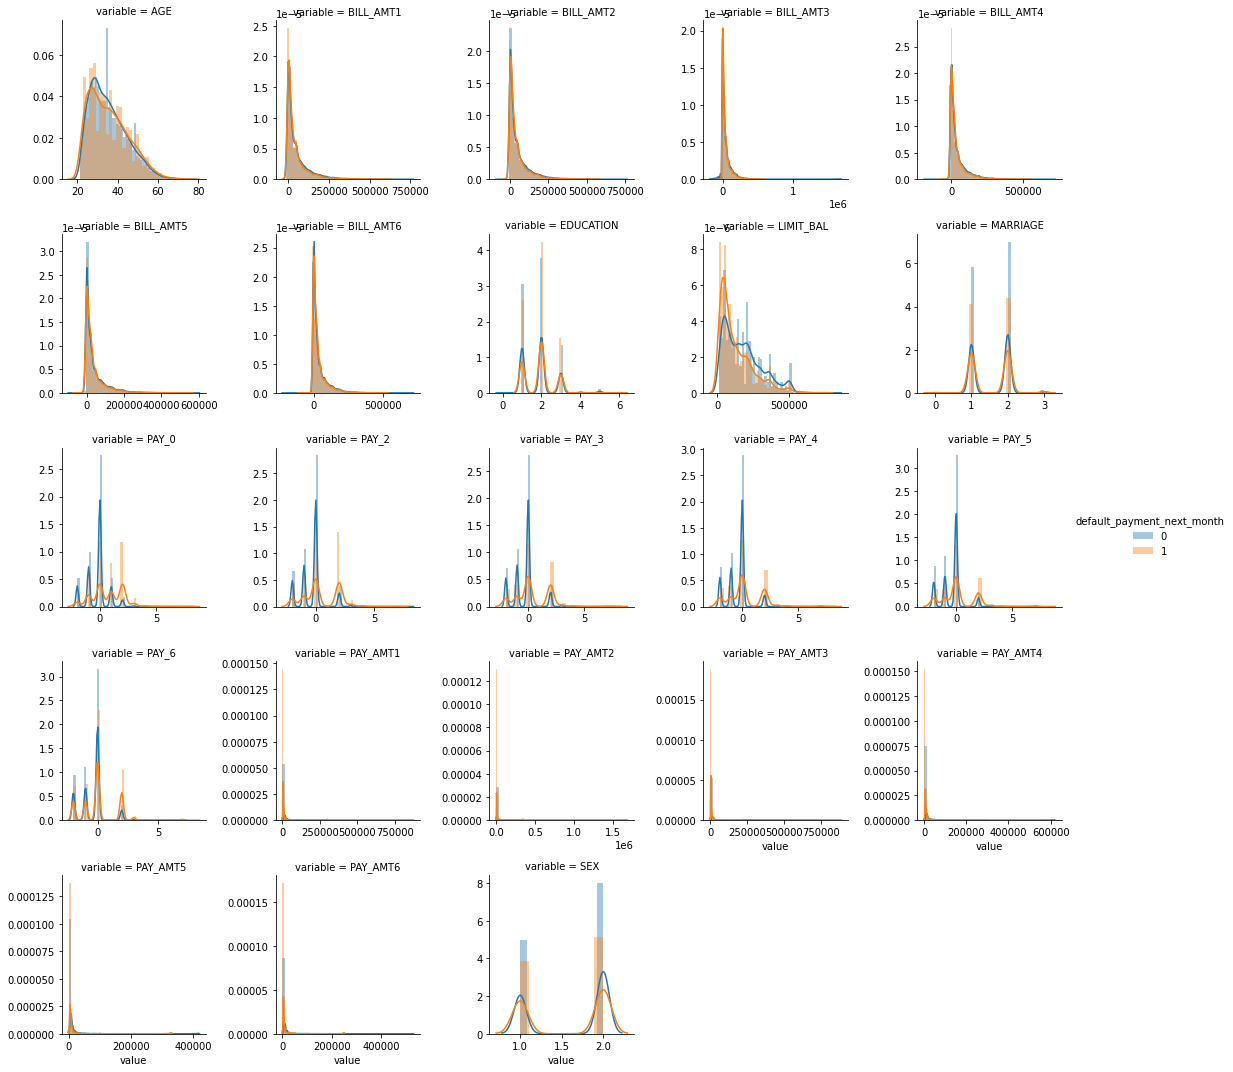

In [6]:
cols = [ f for f in combine.columns if combine.dtypes[ f ] != "object"]
cols.remove( "ID")
cols.remove( output )

f = pd.melt( train, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

In [0]:
def ChiSquaredTestOfIndependence( df, inputVar, Outcome_Category ):
    # Useful to have this wrapped in a function
    # The ChiSquaredTest of Independence - 
    # has a null hypothesis: the OutcomeCategory is independent of the inputVar
    # So we create a test-statistic which is a measure of the difference between 
    # "expected" i.e. what we WOULD observe if the OutcomeCategory WAS independent of the inputVar
    # "observed" i.e. what the data actually shows
    # the p-value returned is the probability of seeing this test-statistic if the null-hypothesis is true
    Outcome_Category_Table = df.groupby( Outcome_Category )[ Outcome_Category ].count().values
    Outcome_Category_Ratios = Outcome_Category_Table / sum( Outcome_Category_Table )
    possibleVals = df[inputVar].unique()
    observed = []
    expected = []
    for possible in possibleVals:
        countsInCategories = df[ df[ inputVar ] == possible ].groupby( Outcome_Category )[Outcome_Category].count().values
        if( len(countsInCategories) != len( Outcome_Category_Ratios ) ):
            print("Error! The class " + str( possible) +" of \'" + inputVar + "\' does not contain all values of \'" + Outcome_Category + "\'" )
            return
        elif( min(countsInCategories) < 5 ):
            print("Chi Squared Test needs at least 5 observations in each cell!")
            print( inputVar + "=" + str(possible) + " has insufficient data")
            print( countsInCategories )
            return
        else:
            observed.append( countsInCategories )   
            expected.append( Outcome_Category_Ratios * len( df[df[ inputVar ] == possible ]))
    observed = np.array( observed )
    expected = np.array( expected )
    chi_squared_stat = ((observed - expected)**2 / expected).sum().sum()
    degOfF = (observed.shape[0] - 1 ) *(observed.shape[1] - 1 ) 
    #crit = stats.chi2.ppf(q = 0.95,df = degOfF) 
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degOfF)
    print("Calculated test-statistic is %.2f" % chi_squared_stat )
    print("If " + Outcome_Category + " is indep of " + inputVar + ", this has prob %.2e of occurring" % p_value )
    #t_stat, p_val, doF, expArray = stats.chi2_contingency(observed= observed, correction=False)
    #print("Using built-in stats test: outputs")
    #print("test-statistic=%.2f, p-value=%.2f, degsOfFreedom=%d" % ( t_stat, p_val, doF ) )

In [8]:
ChiSquaredTestOfIndependence( combine, "SEX", output )

Calculated test-statistic is 2721.65
If default_payment_next_month is indep of SEX, this has prob 0.00e+00 of occurring


In [9]:
# Ok. So "default" is not independent of "SEX". 
ChiSquaredTestOfIndependence( combine, "EDUCATION", output )

Chi Squared Test needs at least 5 observations in each cell!
EDUCATION=4 has insufficient data
[81  4]


In [10]:
print("We have %d with EDUCATION=0" % len(combine.loc[ combine["EDUCATION"]==0]))
print("We have %d with EDUCATION=4" % len(combine.loc[ combine["EDUCATION"]==4]))
print("We have %d with EDUCATION=5" % len(combine.loc[ combine["EDUCATION"]==5]))
print("We have %d with EDUCATION=6" % len(combine.loc[ combine["EDUCATION"]==6]))

We have 14 with EDUCATION=0
We have 123 with EDUCATION=4
We have 280 with EDUCATION=5
We have 51 with EDUCATION=6


In [11]:
# Since we have 30k samples, let's just put these non-typical Education instances all into the EDUCATION=4 class and continue 
combine["EDUCATION_Corr"] = combine["EDUCATION"].apply( lambda x: x if ((x>0) and (x<4)) else 4 )
ChiSquaredTestOfIndependence( combine, "EDUCATION_Corr", output ) 
cols.remove("EDUCATION")
cols.append("EDUCATION_Corr")

ChiSquaredTestOfIndependence( train, "MARRIAGE", output ) 

Calculated test-statistic is 2782.28
If default_payment_next_month is indep of EDUCATION_Corr, this has prob 0.00e+00 of occurring
Chi Squared Test needs at least 5 observations in each cell!
MARRIAGE=0 has insufficient data
[34  2]


In [0]:
# The quantitative vars:
quant = ["LIMIT_BAL", "AGE"]

# The qualitative but "Encoded" variables (ie most of them)
qual_Enc = cols
qual_Enc.remove("LIMIT_BAL")
qual_Enc.remove("AGE")


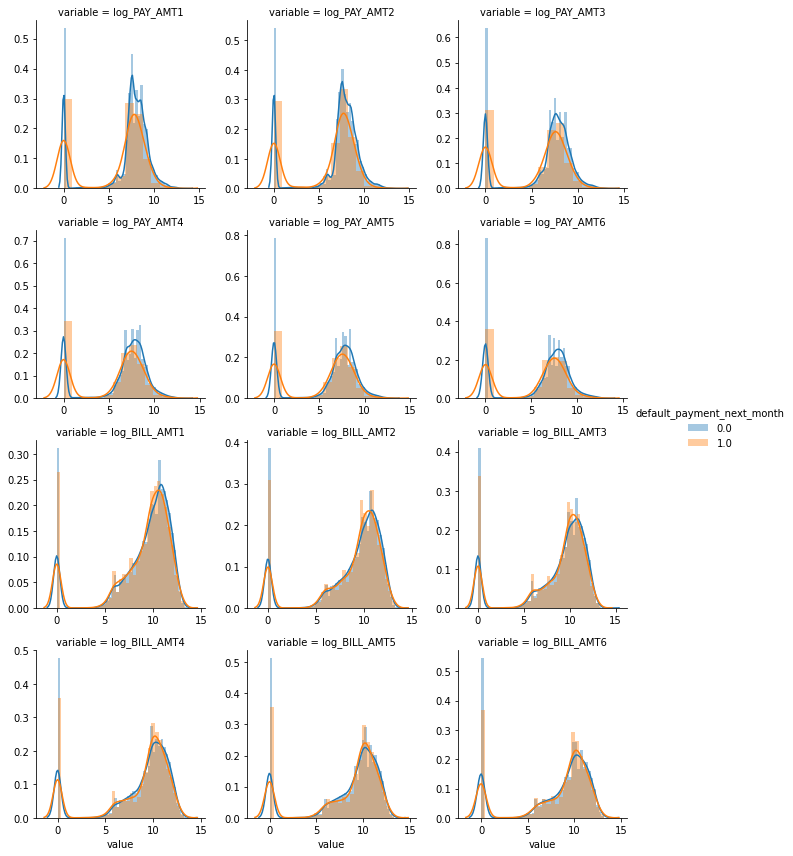

In [13]:
logged = []
for ii in range(1,7):
    qual_Enc.remove("PAY_AMT" + str( ii ))
    combine[ "log_PAY_AMT" + str( ii )]  = combine["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual_Enc.remove("BILL_AMT" + str( ii ))
    combine[ "log_BILL_AMT" + str( ii )] = combine["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( combine, id_vars=output, value_vars=logged)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

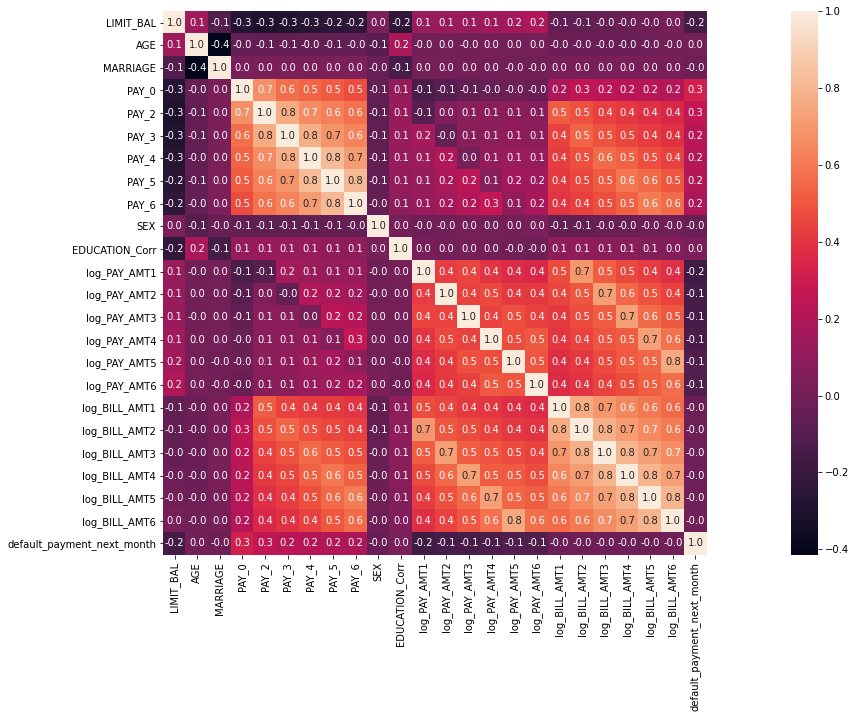

In [14]:
features = quant + qual_Enc + logged + [output]
corr = combine[features].corr()
plt.subplots(figsize=(30,10))
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )

In [0]:
features = quant + qual_Enc + logged

combine_train = combine[combine[output].isnull()==False].copy()
combine_test = combine[combine[output].isnull()==True].copy()
X = combine_train[features].values    
y = combine_train[ output ].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

# We'll need some metrics to evaluate our models
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score 

In [16]:
#-------------- 
# Random Forest 
#--------------
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
rocscore = roc_auc_score( y_test, y_pred )
print("Receiver Operating Characteristic score for RandomForest = ", rocscore)
scoresRF = cross_val_score( classifier, X_train, y_train, cv=10)
print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))

#-------------- 
# kernel SVM 
#--------------
from sklearn.svm import SVC
classifier1 = SVC(kernel="rbf")
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
rocscore = roc_auc_score( y_test, y_pred )
print("Receiver Operating Characteristic score for kernel-SVM = ", rocscore)
scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))

Accuracy on Test Set for RandomForest = 0.80
Receiver Operating Characteristic score for RandomForest =  0.6222355070386779
Mean RandomForest CrossVal Accuracy on Train Set 0.80, with std=0.01
Accuracy on Test Set for kernel-SVM = 0.82
Receiver Operating Characteristic score for kernel-SVM =  0.6449410781993432
Mean kernel-SVM CrossVal Accuracy on Train Set 0.82, with std=0.01


In [17]:
#-------------- 
# Logistic Regression 
#--------------
from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression()
classifier2.fit( X_train, y_train )
y_pred = classifier2.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
rocscore = roc_auc_score( y_test, y_pred )
print("Receiver Operating Characteristic score for Logistic Regression = ", rocscore)
scoresLR = cross_val_score( classifier2, X_train, y_train, cv=10)
print("Mean LogReg CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresLR.mean(), scoresLR.std() ))

#-------------- 
# Naive Bayes 
#--------------
from sklearn.naive_bayes import GaussianNB
classifier3 = GaussianNB()
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for NBClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
rocscore = roc_auc_score( y_test, y_pred )
print("Receiver Operating Characteristic score for Naive Bayes = ", rocscore)
scoresNB = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean NaiveBayes CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresNB.mean(), scoresNB.std() ))

#-------------- 
# K-NEIGHBOURS 
#--------------
from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors=5)
classifier4.fit( X_train, y_train )
y_pred = classifier4.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for KNeighborsClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
rocscore = roc_auc_score( y_test, y_pred )
print("Receiver Operating Characteristic score for K-Neighbors = ", rocscore)
scoresKN = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean KN CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresKN.mean(), scoresKN.std() ))

Accuracy on Test Set for LogReg = 0.80
Receiver Operating Characteristic score for Logistic Regression =  0.6039324876546748
Mean LogReg CrossVal Accuracy on Train Set 0.81, with std=0.01
Accuracy on Test Set for NBClassifier = 0.75
Receiver Operating Characteristic score for Naive Bayes =  0.657856376575411
Mean NaiveBayes CrossVal Accuracy on Train Set 0.76, with std=0.01
Accuracy on Test Set for KNeighborsClassifier = 0.79
Receiver Operating Characteristic score for K-Neighbors =  0.6290850128162082
Mean KN CrossVal Accuracy on Train Set Set 0.76, with std=0.01


In [0]:
#Using Kernel SVM to test combine_test data
test_X = combine_test[features].values
y_pred_test = classifier1.predict(test_X)

In [0]:
submission['default_payment_next_month'] = y_pred_test

In [20]:
submission.to_csv("/content/drive/My Drive/Janata Hack/Janata_final_submission.csv", index= False)
submission.shape

(9000, 2)